In [2]:
import cv2
import numpy as np
from PIL import Image
from rembg import remove
import PIL.Image
import io
from io import StringIO, BytesIO
import IPython.display
import numpy
import ipywidgets
from tha2.util import extract_PIL_image_from_filelike, resize_PIL_image, extract_pytorch_image_from_PIL_image, convert_output_image_from_torch_to_numpy
import tha2.poser.modes.mode_20
import time
import threading
import torch

In [1]:
# Converts an image with a plain background to one
# with a clear background.
# Input:
#   PIL image
# Ouput:
#   PIL image of the image foreground
#   Numpy array of the image background
def remove_bg(img):
    global img2
    img2 = img
    fg = remove(img)
    bg = np.array(img.convert("RGBA"))-np.array(fg)
    return fg, bg

In [69]:
FRAME_RATE = 1.0
DEVICE_NAME = 'cuda'
device = torch.device(DEVICE_NAME)

last_torch_input_image = None
torch_input_image = None

def show_pytorch_image(pytorch_image, output_widget=None, numpy_bg=None):
    output_image = pytorch_image.detach().cpu()
    numpy_image = numpy.uint8(numpy.rint(convert_output_image_from_torch_to_numpy(output_image) * 255.0))
    
    # If the background exists, reapply it so the image isn't so plain
    if numpy_bg is not None:
        numpy_image += numpy_bg
        
    pil_image = PIL.Image.fromarray(numpy_image, mode='RGBA')
    IPython.display.display(pil_image)

input_image_widget = ipywidgets.Output(
    layout={
        'border': '1px solid black',
        'width': '256px',
        'height': '256px'
    })

upload_input_image_button = ipywidgets.FileUpload(
    accept='.png',
    multiple=False,
    layout={
        'width': '256px'
    }
)

output_image_widget = ipywidgets.Output(
    layout={
        'border': '1px solid black',
        'width': '256px',
        'height': '256px'
    }
)

eyebrow_dropdown = ipywidgets.Dropdown(
    options=["troubled", "angry", "lowered", "raised", "happy", "serious"],
    value="troubled",
    description="Eyebrow:",    
)
eyebrow_left_slider = ipywidgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=1.0,
    step=0.01,
    description="Left:",
    readout=True,
    readout_format=".2f"
)
eyebrow_right_slider = ipywidgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=1.0,
    step=0.01,
    description="Right:",
    readout=True,
    readout_format=".2f"
)

eye_dropdown = ipywidgets.Dropdown(
    options=["wink", "happy_wink", "surprised", "relaxed", "unimpressed", "raised_lower_eyelid"],
    value="wink",
    description="Eye:",    
)
eye_left_slider = ipywidgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=1.0,
    step=0.01,
    description="Left:",
    readout=True,
    readout_format=".2f"
)
eye_right_slider = ipywidgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=1.0,
    step=0.01,
    description="Right:",
    readout=True,
    readout_format=".2f"
)

mouth_dropdown = ipywidgets.Dropdown(
    options=["aaa", "iii", "uuu", "eee", "ooo", "delta", "lowered_corner", "raised_corner", "smirk"],
    value="aaa",
    description="Mouth:",    
)
mouth_left_slider = ipywidgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=1.0,
    step=0.01,
    description="Value:",
    readout=True,
    readout_format=".2f"
)
mouth_right_slider = ipywidgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=1.0,
    step=0.01,
    description=" ",
    readout=True,
    readout_format=".2f",
    disabled=True,
)

def update_mouth_sliders(change):
    if mouth_dropdown.value == "lowered_corner" or mouth_dropdown.value == "raised_corner":
        mouth_left_slider.description = "Left:"
        mouth_right_slider.description = "Right:"
        mouth_right_slider.disabled = False
    else:
        mouth_left_slider.description = "Value:"
        mouth_right_slider.description = " "
        mouth_right_slider.disabled = True

mouth_dropdown.observe(update_mouth_sliders, names='value')

iris_small_left_slider = ipywidgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=1.0,
    step=0.01,
    description="Left:",
    readout=True,
    readout_format=".2f"
)
iris_small_right_slider = ipywidgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=1.0,
    step=0.01,
    description="Right:",
    readout=True,
    readout_format=".2f",    
)
iris_rotation_x_slider = ipywidgets.FloatSlider(
    value=0.0,
    min=-1.0,
    max=1.0,
    step=0.01,
    description="X-axis:",
    readout=True,
    readout_format=".2f"
)
iris_rotation_y_slider = ipywidgets.FloatSlider(
    value=0.0,
    min=-1.0,
    max=1.0,
    step=0.01,
    description="Y-axis:",
    readout=True,
    readout_format=".2f",    
)

head_x_slider = ipywidgets.FloatSlider(
    value=0.0,
    min=-1.0,
    max=1.0,
    step=0.01,
    description="X-axis:",
    readout=True,
    readout_format=".2f"
)
head_y_slider = ipywidgets.FloatSlider(
    value=0.0,
    min=-1.0,
    max=1.0,
    step=0.01,
    description="Y-axis:",
    readout=True,
    readout_format=".2f",    
)
neck_z_slider = ipywidgets.FloatSlider(
    value=0.0,
    min=-1.0,
    max=1.0,
    step=0.01,
    description="Z-axis:",
    readout=True,
    readout_format=".2f",    
)


control_panel = ipywidgets.VBox([
    eyebrow_dropdown,
    eyebrow_left_slider,
    eyebrow_right_slider,
    ipywidgets.HTML(value="<hr>"),
    eye_dropdown,
    eye_left_slider,
    eye_right_slider,
    ipywidgets.HTML(value="<hr>"),
    mouth_dropdown,
    mouth_left_slider,
    mouth_right_slider,
    ipywidgets.HTML(value="<hr>"),
    ipywidgets.HTML(value="<center><b>Iris Shrinkage</b></center>"),
    iris_small_left_slider,
    iris_small_right_slider,
    ipywidgets.HTML(value="<center><b>Iris Rotation</b></center>"),
    iris_rotation_x_slider,
    iris_rotation_y_slider,
    ipywidgets.HTML(value="<hr>"),
    ipywidgets.HTML(value="<center><b>Head Rotation</b></center>"),
    head_x_slider,
    head_y_slider,
    neck_z_slider,
])

controls = ipywidgets.HBox([
    ipywidgets.VBox([
        input_image_widget, 
        upload_input_image_button
    ]),
    control_panel,
    ipywidgets.HTML(value="&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"),
    output_image_widget,
])

poser = tha2.poser.modes.mode_20.create_poser(device)
pose_parameters = tha2.poser.modes.mode_20.get_pose_parameters()
pose_size = poser.get_num_parameters()
last_pose = torch.zeros(1, pose_size).to(device)

iris_small_left_index = pose_parameters.get_parameter_index("iris_small_left")
iris_small_right_index = pose_parameters.get_parameter_index("iris_small_right")
iris_rotation_x_index = pose_parameters.get_parameter_index("iris_rotation_x")
iris_rotation_y_index = pose_parameters.get_parameter_index("iris_rotation_y")
head_x_index = pose_parameters.get_parameter_index("head_x")
head_y_index = pose_parameters.get_parameter_index("head_y")
neck_z_index = pose_parameters.get_parameter_index("neck_z")

def get_pose():
    pose = torch.zeros(1, pose_size)

    eyebrow_name = f"eyebrow_{eyebrow_dropdown.value}"
    eyebrow_left_index = pose_parameters.get_parameter_index(f"{eyebrow_name}_left")
    eyebrow_right_index = pose_parameters.get_parameter_index(f"{eyebrow_name}_right")
    pose[0, eyebrow_left_index] = eyebrow_left_slider.value
    pose[0, eyebrow_right_index] = eyebrow_right_slider.value

    eye_name = f"eye_{eye_dropdown.value}"
    eye_left_index = pose_parameters.get_parameter_index(f"{eye_name}_left")
    eye_right_index = pose_parameters.get_parameter_index(f"{eye_name}_right")
    pose[0, eye_left_index] = eye_left_slider.value
    pose[0, eye_right_index] = eye_right_slider.value

    mouth_name = f"mouth_{mouth_dropdown.value}"
    if mouth_name == "mouth_lowered_corner" or mouth_name == "mouth_raised_corner":
        mouth_left_index = pose_parameters.get_parameter_index(f"{mouth_name}_left")
        mouth_right_index = pose_parameters.get_parameter_index(f"{mouth_name}_right")
        pose[0, mouth_left_index] = mouth_left_slider.value
        pose[0, mouth_right_index] = mouth_right_slider.value
    else:
        mouth_index = pose_parameters.get_parameter_index(mouth_name)
        pose[0, mouth_index] = mouth_left_slider.value

    pose[0, iris_small_left_index] = iris_small_left_slider.value
    pose[0, iris_small_right_index] = iris_small_right_slider.value
    pose[0, iris_rotation_x_index] = iris_rotation_x_slider.value
    pose[0, iris_rotation_y_index] = iris_rotation_y_slider.value
    pose[0, head_x_index] = head_x_slider.value
    pose[0, head_y_index] = head_y_slider.value
    pose[0, neck_z_index] = neck_z_slider.value

    return pose.to(device)

display(controls)

def update(change):
    global last_pose
    global last_torch_input_image

    if torch_input_image is None:
        return

    needs_update = False
    if last_torch_input_image is None:
        needs_update = True        
    else:
        if (torch_input_image - last_torch_input_image).abs().max().item() > 0:
            needs_update = True         

    pose = get_pose()
    if (pose - last_pose).abs().max().item() > 0:
        needs_update = True
        
    global change2
    change2 = change
    global pose2
    pose2 = pose

    if not needs_update:
        return

    output_image = poser.pose(torch_input_image, pose)[0]
    with output_image_widget:
        output_image_widget.clear_output(wait=True)
        show_pytorch_image(output_image, output_image_widget)  

    last_torch_input_image = torch_input_image
    last_pose = pose

def upload_image(change):
    global torch_input_image
    for name, file_info in upload_input_image_button.value.items():
        content = io.BytesIO(file_info['content'])
    if content is not None:
        pil_image = resize_PIL_image(extract_PIL_image_from_filelike(content)).convert('RGB')
        
        # Remove the background from the image and save the background
        # for later use
        pil_image, bg = remove_bg(pil_image)
        
        # Save the numpy background so that it can
        # be reapplied when showing the image
        global numpy_bg
        numpy_bg = None
        bg = bg.transpose(2, 0, 1)
        # Note: alpha values with 0 and 100% transparent and alpha values at 255
        # are 100 not transparent. So instead of keeping the trash artifacts
        # that may mess up the original image when adding this mask to it, we
        # can just remove anything we don't want. Since the BG is found really well,
        # this method mostly works and has a slight issue around the border, but
        # it's better than having annoying artifacts.
        numpy_bg = Image.fromarray(numpy.where(bg[-1] > 10, bg, 0).transpose(1, 2, 0))
        
        w, h = pil_image.size
        if pil_image.mode != 'RGBA':
            with input_image_widget:
                input_image_widget.clear_output(wait=True)
                display(ipywidgets.HTML("Image must have an alpha channel!!!"))
        else:
            global numpy_img
            torch_input_image = extract_pytorch_image_from_PIL_image(pil_image).to(device)
            numpy_img = torch_input_image
            with input_image_widget:
                input_image_widget.clear_output(wait=True)
                show_pytorch_image(torch_input_image, input_image_widget)
        update(None)

upload_input_image_button.observe(upload_image, names='value')
eyebrow_dropdown.observe(update, 'value')
eyebrow_left_slider.observe(update, 'value')
eyebrow_right_slider.observe(update, 'value')
eye_dropdown.observe(update, 'value')
eye_left_slider.observe(update, 'value')
eye_right_slider.observe(update, 'value')
mouth_dropdown.observe(update, 'value')
mouth_left_slider.observe(update, 'value')
mouth_right_slider.observe(update, 'value')
iris_small_left_slider.observe(update, 'value')
iris_small_right_slider.observe(update, 'value')
iris_rotation_x_slider.observe(update, 'value')
iris_rotation_y_slider.observe(update, 'value')
head_x_slider.observe(update, 'value')
head_y_slider.observe(update, 'value')

In [66]:
# It looks like change tells the model how to change. Duh. Not
# much I can use here though
change2

{'name': 'value',
 'old': 'troubled',
 'new': 'angry',
 'owner': Dropdown(description='Eyebrow:', index=1, options=('troubled', 'angry', 'lowered', 'raised', 'happy', 'serious'), value='angry'),
 'type': 'change'}

In [61]:
# It looks like /pose keeps the pose of the image in a 42-dim vector
# in the following way:
#   eyebrow:
#      0: troubled left %
#      1: troubled right %
#      2: angry left %
#      3: angry right %
#      4: lowered left %
#      5: lowered right %
#      6: raised left %
#      7: riased right %
#      8: happy left %
#      9: happy right %
#     10: serious left %
#     11: serious right %
#   eye:
#     12: wink right %
#     13: wink left %
#     14: happy wink right %
#     15: happy wink left %
#     16: surprised left %
#     17: surprised right %
#     18: relaxed left %
#     19: relaxed right %
#     20: unimpressed left %
#     21: unimpressed right %
#     22: raised_lower_eyelid left %
#     23: raised_lower_eyelid right %
#   iris shrinkage:
#     24: left %
#     25: right %
#   mouth:
#     26: aaa %
#     27: iii %
#     28: uuu %
#     29: eee %
#     30: ooo %
#     31: delta %
#     32: lowered_corner left %
#     33: lowered_corner right %
#     34: raised_corner left %
#     35: raised_corner right %
#     36: smirk %
#   iris rotation:
#     37: left % (between -1 and 1)
#     38: right % (between -1 and 1)
#   head rotation:
#     39: x-axis % (between -1 and 1)
#     40: y-axis % (between -1 and 1)
#     41: z-axis % (between -1 and 1)
pose2

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.4300,  0.4000, -0.5100,
         -1.0000,  0.7700]], device='cuda:0')

Gonna try to make my own little thing to see how it works in detail

In [98]:
# Converts an image with a plain background to one
# with a clear background.
# Input:
#   PIL image
# Ouput:
#   PIL image of the image foreground
#   Numpy array of the image background
def remove_bg(img):
    global img2
    img2 = img
    fg = remove(img)
    bg = np.array(img.convert("RGBA"))-np.array(fg)
    return fg, bg

In [100]:
def show_pytorch_image(pytorch_image, output_widget=None, numpy_bg=None):
    output_image = pytorch_image.detach().cpu()
    numpy_image = numpy.uint8(numpy.rint(convert_output_image_from_torch_to_numpy(output_image) * 255.0))
    
    # If the background exists, reapply it so the image isn't so plain
    if numpy_bg is not None:
        numpy_image += numpy_bg
        
    pil_image = PIL.Image.fromarray(numpy_image, mode='RGBA')
    IPython.display.display(pil_image)

In [108]:
def change_pose(pose):
    # Load in the image
    img = Image.open("data/illust/img.png").convert("RGB")
    
    # Image must be 256x256
    img = img.resize((256, 256))
        
    # Remove the background from the image and save the background
    # for later use
    img, bg = remove_bg(img)

    # Save the numpy background so that it can
    # be reapplied when showing the image
    # Note: alpha values with 0 and 100% transparent and alpha values at 255
    # are 100 not transparent. So instead of keeping the trash artifacts
    # that may mess up the original image when adding this mask to it, we
    # can just remove anything we don't want. Since the BG is found really well,
    # this method mostly works and has a slight issue around the border, but
    # it's better than having annoying artifacts.
    numpy_bg = Image.fromarray(numpy.where(bg.transpose(2, 0, 1)[-1] > 10, bg.transpose(2, 0, 1), 0).transpose(1, 2, 0))
    
    # Make the image a torch tensor
    print(np.array(img).shape)
    torch_input_image = extract_pytorch_image_from_PIL_image(img).to(device)
    
    # Now let's try to get the output image with no posing
    output_image = poser.pose(torch_input_image, pose)[0]
    
    # Show the image
    show_pytorch_image(output_image, numpy_bg=numpy_bg)

(256, 256, 4)


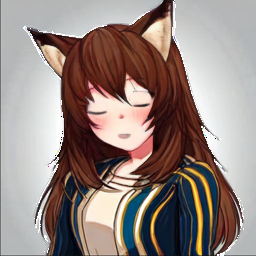

In [119]:
# Posing vector
pose = torch.zeros((42)).to(device)

# Let's make the right eye closed
pose[12] = 1
# Let's make the left eye closed too
pose[13] = 1

# Let's also make the mouth open 70%
pose[26] = 0.7


change_pose(pose)

In [120]:
# Ok cool. Now I need to make the function faster

In [122]:
def change_pose(pose, torch_input_image, numpy_bg):
    # Now let's try to get the output image with no posing
    output_image = poser.pose(torch_input_image, pose)[0]
    
    # Show the image
    show_pytorch_image(output_image, numpy_bg=numpy_bg)

In [123]:
def load_img(path):
    # Load in the image
    img = Image.open(path).convert("RGB")
    
    # Image must be 256x256
    img = img.resize((256, 256))
        
    # Remove the background from the image and save the background
    # for later use
    img, bg = remove_bg(img)

    # Save the numpy background so that it can
    # be reapplied when showing the image
    # Note: alpha values with 0 and 100% transparent and alpha values at 255
    # are 100 not transparent. So instead of keeping the trash artifacts
    # that may mess up the original image when adding this mask to it, we
    # can just remove anything we don't want. Since the BG is found really well,
    # this method mostly works and has a slight issue around the border, but
    # it's better than having annoying artifacts.
    numpy_bg = Image.fromarray(numpy.where(bg.transpose(2, 0, 1)[-1] > 10, bg.transpose(2, 0, 1), 0).transpose(1, 2, 0))
    
    # Make the image a torch tensor
    torch_input_image = extract_pytorch_image_from_PIL_image(img).to(device)
    
    return torch_input_image, numpy_bg

In [124]:
# Load in the image
torch_input_image, numpy_bg = load_img("data/illust/img.png")

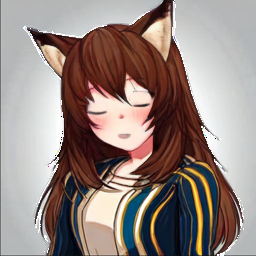

In [126]:
# Posing vector
pose = torch.zeros((42)).to(device)

# Let's make the right eye closed
pose[12] = 1
# Let's make the left eye closed too
pose[13] = 1

# Let's also make the mouth open 70%
pose[26] = 0.7

# Change the pose
change_pose(pose, torch_input_image, numpy_bg)

In [134]:
import time
from IPython.display import clear_output

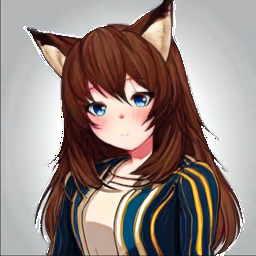

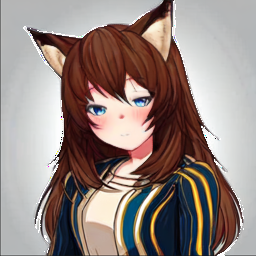

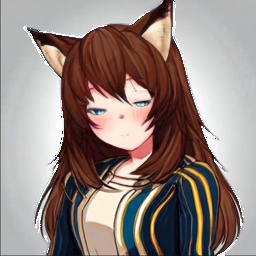

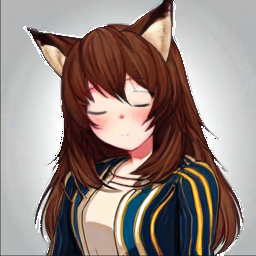

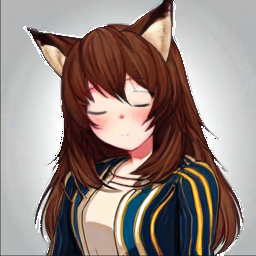

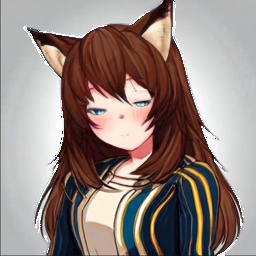

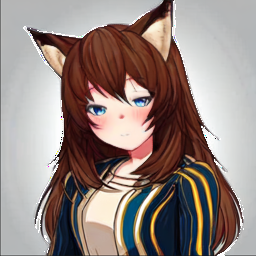

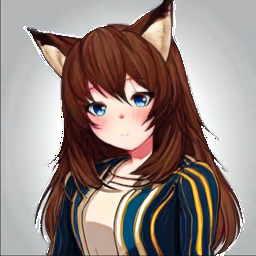

In [153]:
# Posing vector
pose = torch.zeros((42)).to(device)

length = 3

# What if we try to make her blink?
for pos in range(0, length+1):
    pos /= length
    # Let's make the right eye closed
    pose[12] = pos
    # Let's make the left eye closed too
    pose[13] = pos
    
    # Change the pose
    change_pose(pose, torch_input_image, numpy_bg)

    # What if we try to make her blink?
for pos in range(length, -1, -1):
    pos /= length
    # Let's make the right eye closed
    pose[12] = pos
    # Let's make the left eye closed too
    pose[13] = pos
    
    # Change the pose
    change_pose(pose, torch_input_image, numpy_bg)